# GPs. Notebook 2. Gaussian Processes for Classification

------------------------------------------------------
*Machine Learning, Master in Information & Health Engineering

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

Today, we will learn two important aspects of learning with Gaussian Processes. First, how to use them to perform [binary classification](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf). And second, about [Sparse GPs](http://mlg.eng.cam.ac.uk/zoubin/papers/aistats07localGP.pdf), that aims at selecting a subset of points to represent the GP and thus lower down its complexity, since future prediction don't rely on the entire dataset.

Recommended Bibliography:

- [An introduction to Gaussian Processes](http://www.inference.org.uk/mackay/gpB.pdf), by David J.C. Mackay
- Chapter 6 of [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf), David Barber, 2010
- Chapter 15 of Machine Learning: a probabilistic perspective, Kevin Murphy 2012
- [Gaussian Processes for Machine Learning](Gaussian Processes for Machine Learning), by Carl Edward Rasmussen and Christopher K. I. Williams. 

And these slides are really nice

-[A Tutorial on Gaussian Processes (or why I don’t use SVMs)](http://mlss2011.comp.nus.edu.sg/uploads/Site/lect1gp.pdf), by Zoubin Ghahramani

About Sparse GPs:
- [James Hensman Leture at the 2013 Gaussian Process Summer School](https://www.youtube.com/watch?v=66vH34Ykfo0) (Video) and [slides](http://gpss.cc/gpss13/assets/Sheffield-GPSS2013-Hensman.pdf).


**The following examples are mainly based on the tutorials included in the GPy official documentation**. I added some more details and interpretations, but everything is based on their exellent work!

## Installing and importing GPy Library

[GPy](https://sheffieldml.github.io/GPy/) is a Gaussian Process (GP) framework written in python, from the Sheffield machine learning group. 

We asume GPy is already installed in your computer. If is not, follow the instructions provided in their [Github repository](https://github.com/SheffieldML/GPy). 

In [1]:
# You can also install GPy using the following command (Works on Windows too!)

#!pip install GPy 

In [2]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

# Gaussian Processes for Classification

Gaussian Process classification is perhaps the most popular case of a GP model where the likelihood is not conjugate to the prior. In the classification case, the likelihood is Bernoulli, and we must perform approximate inference over the values of the function. There are many approaches to making such an approximation: here we'll start with the popular Laplace approximation. Be aware there are some more accurate approximations such as the [EP method](https://tminka.github.io/papers/ep/roadmap.html).

## Toy Example.

To illustate GP classification, we will create a **generative model**. In classification, we consider the labels (0 or 1) to be generated by a conditional distribution given the inputs, $\mathbf{X}$.

In GP classification, the model is that there is a hidden function, drawn from a GP, which takes continuous values. Those values are then squashed through a probit or signmoid function, into the range [0,1], and can then be used as probabilities. Bernoulli draws are then made (taking the values 0 or 1) conditioned on the squashed values. Namely,

\begin{align}
P(y=+1|\mathbf{x})=\frac{1}{1+\text{e}^{f(\mathbf{x})}},
\end{align}
where $f(\mathbf{x})$ is the Gaussian Process.

First we'll set up a kernel for the GP from which to draw some latent function values (a candidate hidden function for the above generative model), given some arbitrary positions X
at which we get observations.

Text(0, 0.5, '$f(x)$')

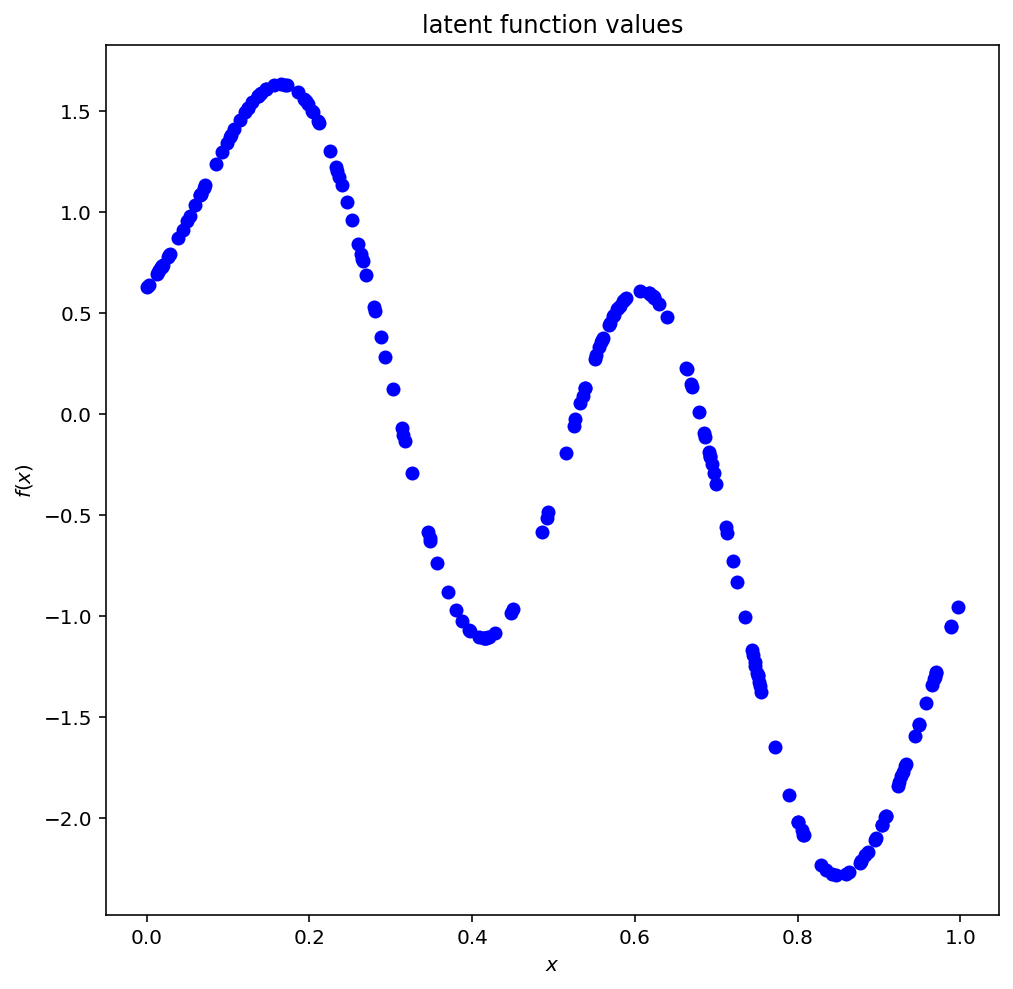

In [3]:
k = GPy.kern.RBF(1, variance=7., lengthscale=0.2)
X = np.random.rand(200,1)

#draw the latent function value
f = np.random.multivariate_normal(np.zeros(200), k.K(X))

plt.plot(X, f, 'bo')
plt.title('latent function values');plt.xlabel('$x$');plt.ylabel('$f(x)$')

Now we'll squash the latent function values through the sigmoid function. We'll set up a GPy likelihood for this, which contains the squashing function as well as assorted mechanisms for doing approximate inference.

Text(0, 0.5, '$\\sigma(f(x))$')

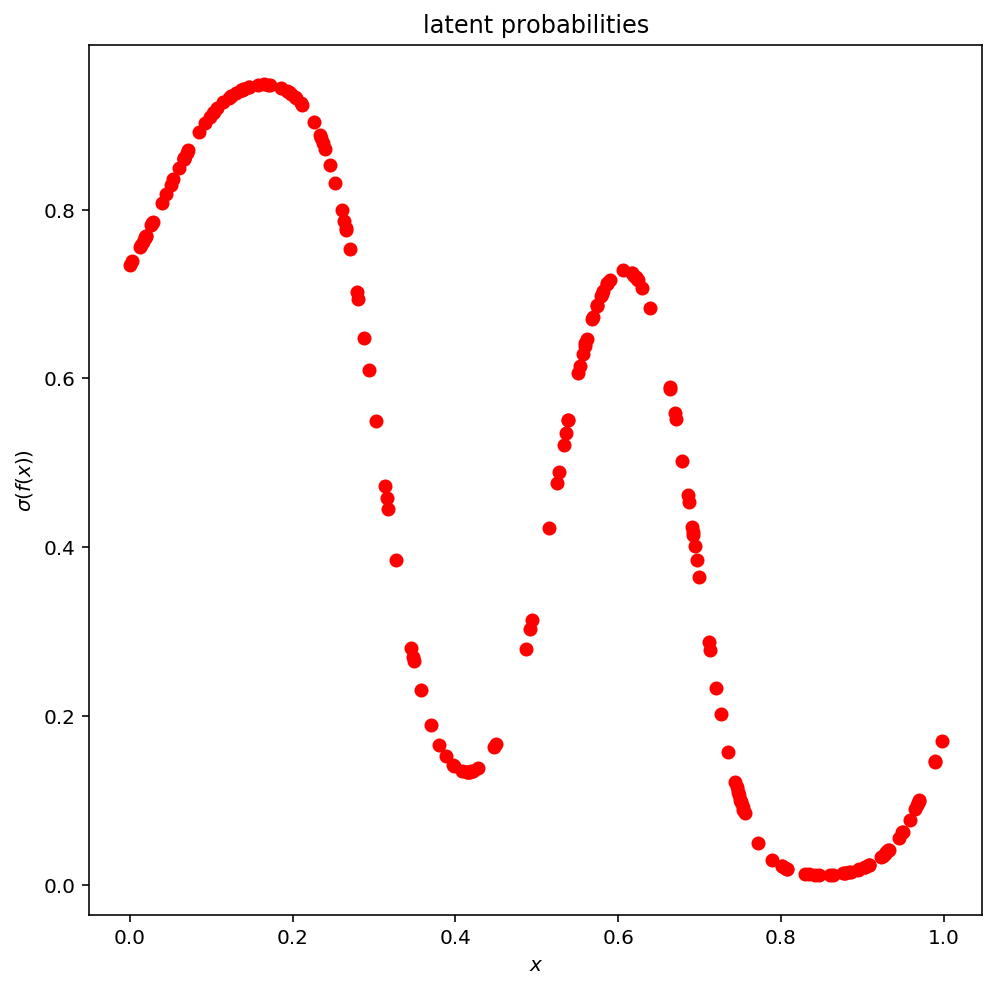

In [9]:
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f) # squash the latent function
plt.plot(X, p, 'ro')
plt.title('latent probabilities');plt.xlabel('$x$');plt.ylabel('$\sigma(f(x))$')

Now binary Bernoulli variables are drawn using the squashed values of our latent function as probabilities:

Text(0, 0.5, '$y \\in \\{0,1\\}$')

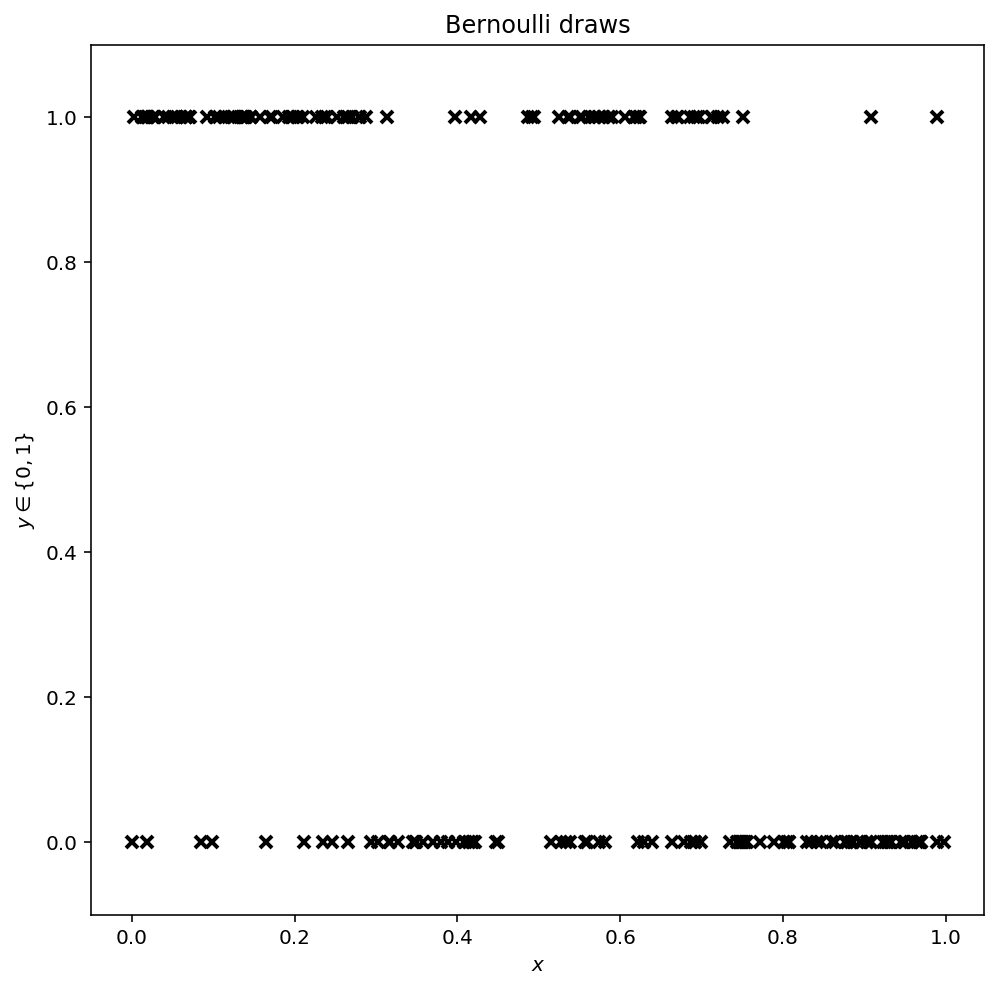

In [10]:
Y = lik.samples(f).reshape(-1,1)
plt.plot(X, Y, 'kx', mew=2);plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws');plt.xlabel('$x$');plt.ylabel('$y \in \{0,1\}$')

### Inference

We have now generated some data from our proposed model. We'll now attempt to train a GP classifier using the generated data.

In this case we wish to know, **given the observed binary variables, can we recover the latent function, the associated probabilities, and the variance and lengthscale of the GP that we believe produced the data?**

We'll set up a GPy classifier to do this. first we'll use the most general setup for defining a GP object in GPy, allowing us to select the EP inference method and use our existing likelihood and kernel.

In [12]:
new_kernel = GPy.kern.RBF(1, variance=1., lengthscale=1.)

m = GPy.core.GP(X=X,
                Y=Y, 
                kernel=new_kernel, 
                inference_method=GPy.inference.latent_function_inference.Laplace(),
                likelihood=lik)

'''

To use EP approximations instead of Laplace

m = GPy.core.GP(X=X,
                Y=Y, 
                kernel=new_kernel, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
'''

print(m)


Name : gp
Objective : 114.55929621056804
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


There's a simpler way to build GP classifiers, with some default options (RBF kernel, EP inference) like so:

In [7]:
m = GPy.models.GPClassification(X,Y)

This model is initialized with incorrect lengthscale and variance, but let's check out how it's fared in inferring the latent fuction values. We can easily observe that the GP is not yet tuned by **plotting the true probabilities and the GP estimated ones (mean and confidence)**.

**Note:** The parameters of the kernel are not tuned, but we have already run inference through  Laplace in order to estimate $p(f(x)|y)$ and $p(y|\text{data})$.

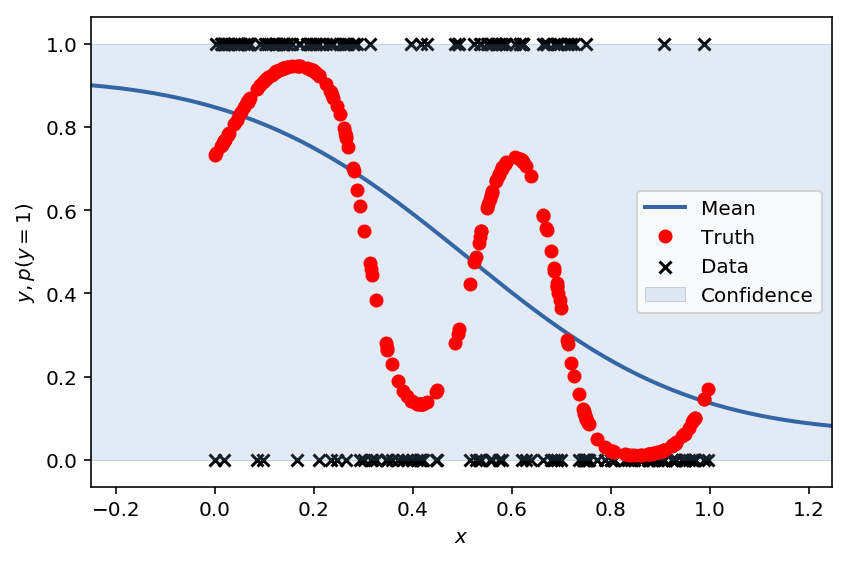

In [8]:
m.plot()
plt.plot(X, p, 'ro',label='Truth')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.legend()

Also, the true latent values of the ones estimated by the GP:

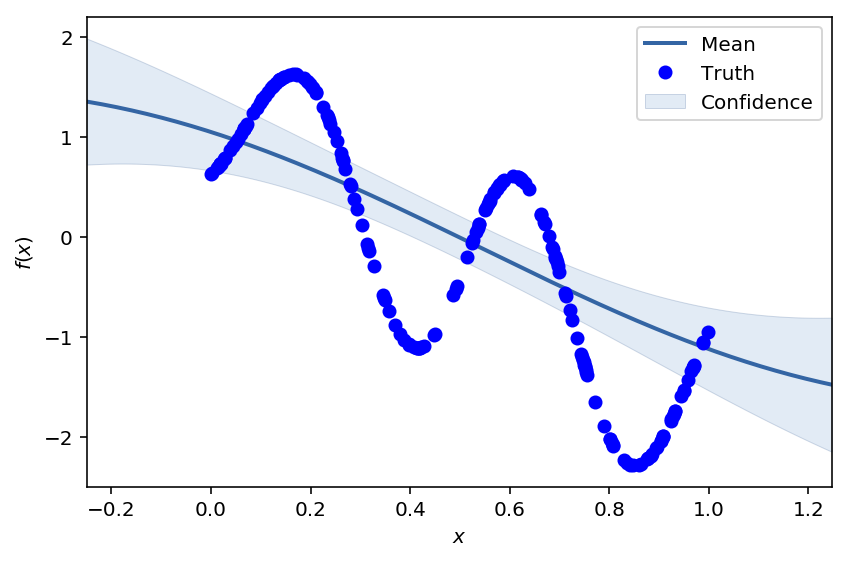

In [9]:
m.plot_f()
plt.plot(X, f, 'bo',label='Truth')
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend()


The above plots suggest that **the parameters of the kernel are incorrect for this problem**, so we'll optimize the parameters of the kernel against the approximate marginal likelihood, p(y|M), that represents how probable the data is given our model, $M$.

To do this, we interleave runs of Laplace approximation with optimization of the parameters using gradient descent methods.  Laplace is a method for fitting a Gaussian to the posterior, $p(f|y)$, of the latent (hidden) function, given the data. Whilst the parameters are being optimized, the  Laplace approximation  is fixed.

In [13]:
print (m, '\n')
for i in range(5):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
    print('iteration:', i,'\n')
    print(m,'\n')


Name : gp
Objective : 114.55929621056804
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |         

iteration: 0 


Name : gp
Objective : 99.62898062281599
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |                value  |  constraints  |  priors
  rbf.variance     |   1.2413081787463345  |      +ve      |        
  rbf.lengthscale  |  0.13735659154648536  |      +ve      |         

iteration: 1 


Name : gp
Objective : 99.62898062281599
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |                value  |  constraints  |  priors
  rbf.variance     |   1.2413081787463345  |      +ve      |        
  rbf.lengthscale  |  0.13735659154648536  |      +ve      |  

Now our parameters have been optimised to the values that give the largest marginal likelihood, we can plot the results to see how they differ

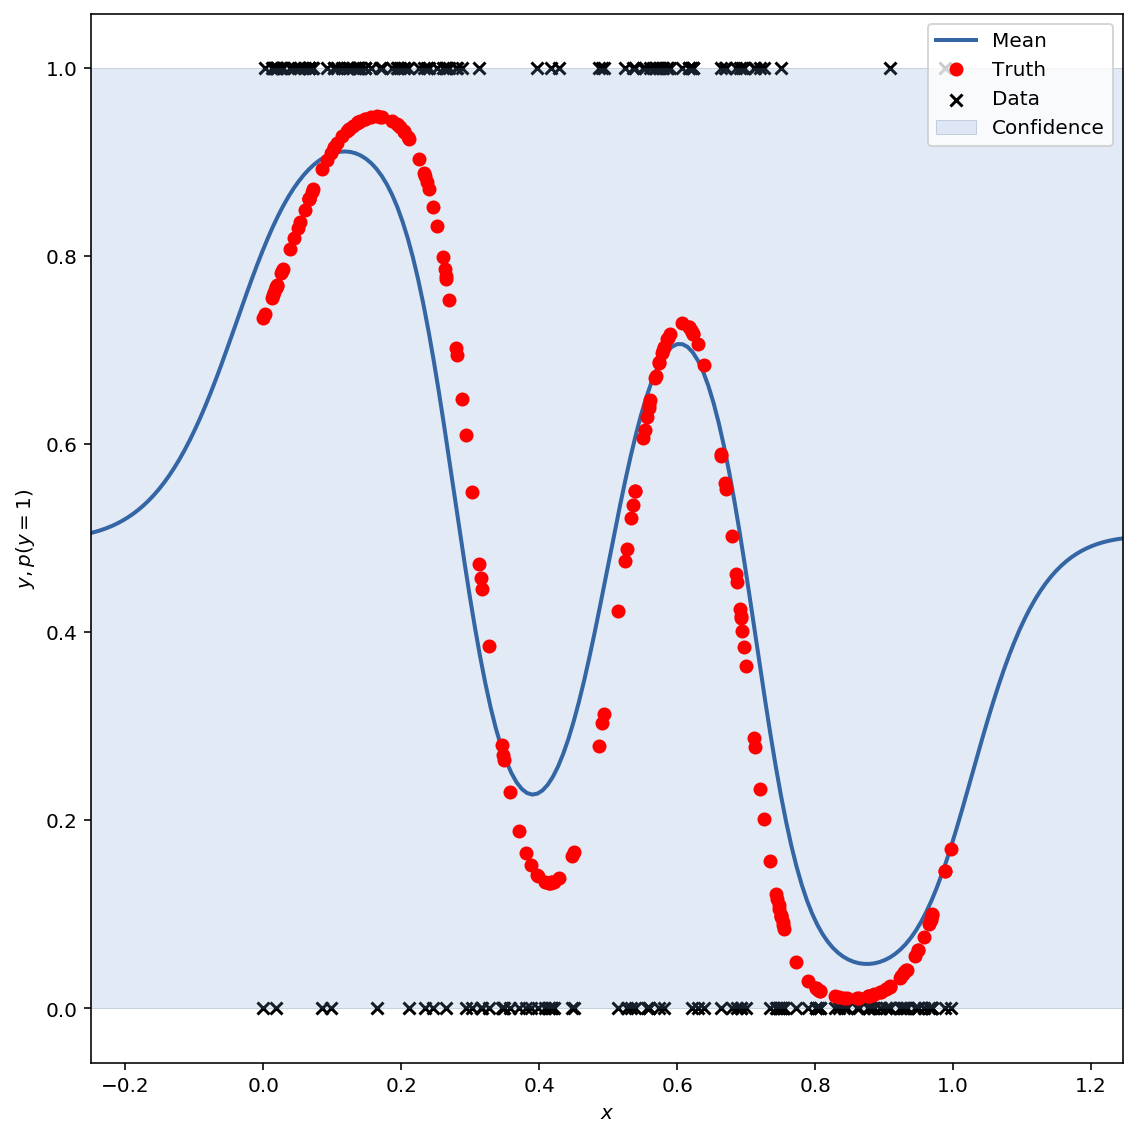

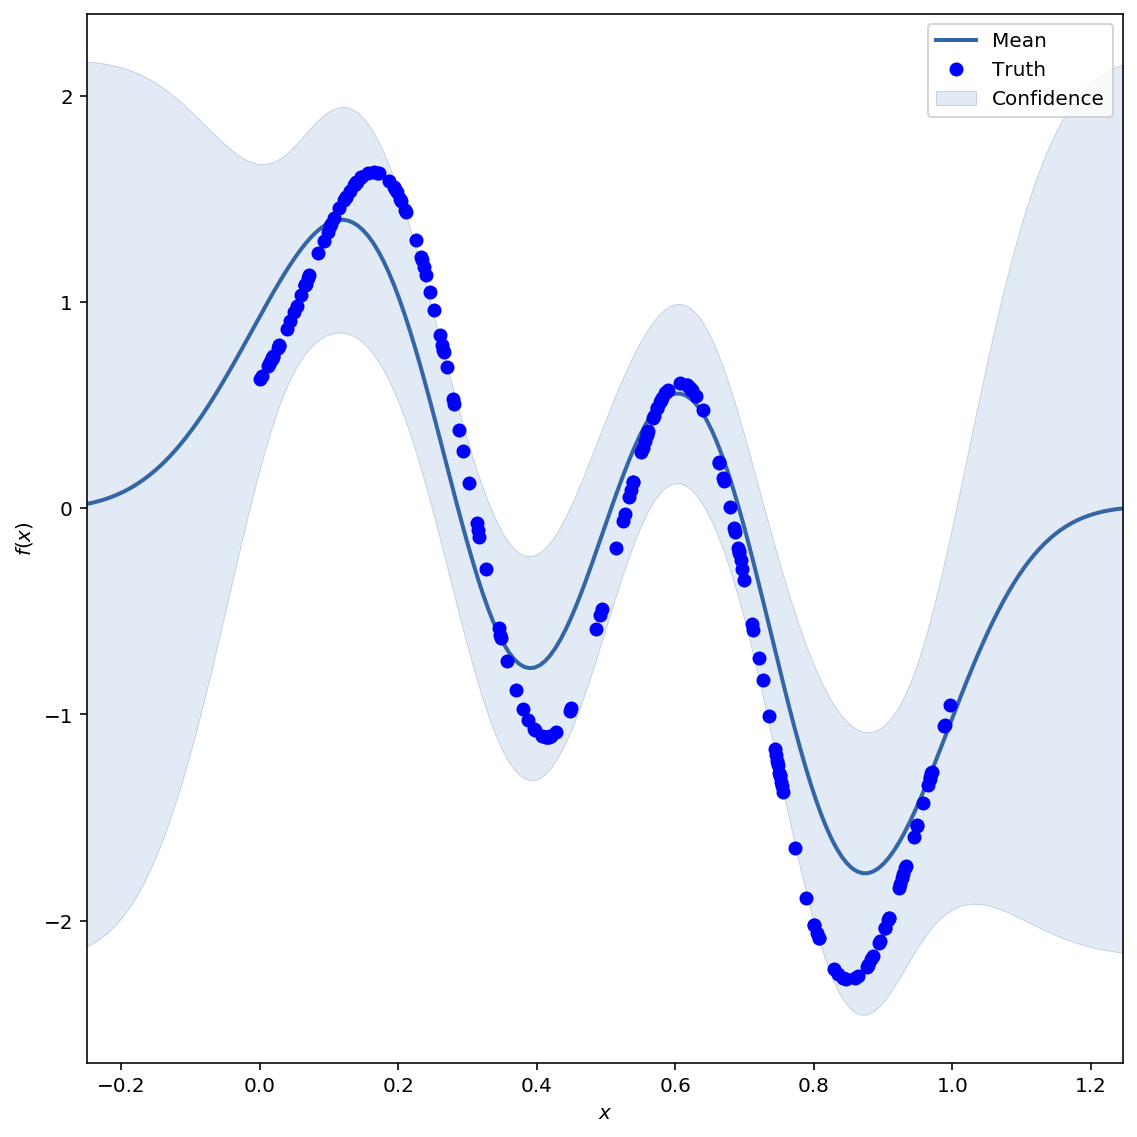

In [14]:
m.plot()
plt.plot(X, p, 'ro', label='Truth')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.legend()

m.plot_f()
plt.plot(X, f, 'bo', label='Truth')
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend()

We've seen the generating process for GP classification, and how to set up models in GPy to do classification. We've used Laplace method to infer the latent function, interleaved with optimization of the kernel parameters. 